In [24]:
subj = "Subj1"
exp = "exp1"

### Imports

In [25]:
%load_ext autoreload
%autoreload 2

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [26]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 3)


In [27]:
import sklearn.preprocessing
features = sklearn.preprocessing.StandardScaler().fit_transform(features)

### SDA

In [28]:
result, df_st_edges = SDA.SDA().apply(features)

Applying to 1046 samples with 3 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [29]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

#### Find best result

In [30]:
results = SDA.analytics.best_results(result, key = 'Avg-Silh')
results.to_csv(f"{subj}/{exp}/results.csv")
display(results)

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
4,0,35,15,3,Mode,"[0, 52, 670, 1046]",242.79,1.73,0.02,110.88,2.85,0.18,103.10,2.35
22,0,45,15,4,Mode,"[0, 52, 670, 800, 1046]",223.24,1.74,-0.02,92.33,3.51,0.18,95.03,1.78
22,0,45,15,5,Mode,"[0, 52, 252, 670, 800, 1046]",177.40,1.40,-0.01,122.25,16.68,0.16,96.56,1.85
84,40,40,15,6,Median,"[0, 52, 252, 566, 670, 855, 1046]",168.30,1.42,-0.03,111.24,4.40,0.16,92.39,1.89
88,40,40,20,7,Mode,"[0, 52, 252, 490, 566, 670, 862, 1046]",143.38,1.37,-0.04,95.84,4.87,0.16,81.37,1.98
123,60,40,20,8,Median,"[0, 105, 252, 490, 566, 670, 855, 975, 1046]",118.05,1.28,-0.05,87.22,6.39,0.15,64.63,2.13
123,60,40,20,9,Median,"[0, 105, 252, 345, 490, 566, 670, 855, 975, 1046]",89.95,1.15,-0.06,77.21,6.46,0.13,48.78,2.58
15,0,40,20,10,Median,"[0, 52, 252, 388, 490, 572, 670, 749, 857, 955...",74.35,1.08,-0.07,67.02,6.61,0.12,42.82,3.07
132,60,45,20,11,Median,"[0, 105, 137, 252, 390, 490, 566, 670, 789, 85...",54.93,0.98,-0.09,63.47,7.91,0.10,29.10,3.09
15,0,40,20,12,Median,"[0, 52, 105, 252, 388, 490, 566, 609, 670, 749...",48.53,1.00,-0.11,59.58,6.08,0.10,27.83,2.92


In [31]:
best_result = SDA.analytics.best_result(result, key = 'Avg-Silh', n_stages = 10)
best_edges = numpy.array(best_result['St_edges'])
numpy.savetxt(f"{subj}/{exp}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
display(best_edges)
# 0 92 154 282 492 560 682 784 857 976 1046
# array([   0,   52,  252,  388,  490,  572,  670,  749,  857,  955, 1046])

array([   0,   52,  252,  388,  490,  572,  670,  749,  857,  955, 1046])

#### Edge stats

In [32]:
edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
edge_statistics.to_csv(f"{subj}/{exp}/edge_statistics.csv")
display(edge_statistics)

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.24,90.31,1.16,118.22,1.69
1,0.23,137.39,1.40,207.36,1.60
2,0.02,7.56,4.99,12.84,0.47
3,0.05,12.78,3.43,24.35,0.73
4,0.08,23.32,2.51,47.97,1.04
5,0.18,55.23,1.63,115.92,1.63
6,0.02,5.45,5.34,11.74,0.51
7,0.18,48.22,1.84,117.28,1.51
8,0.03,5.13,5.36,13.46,0.53


#### Feature plots

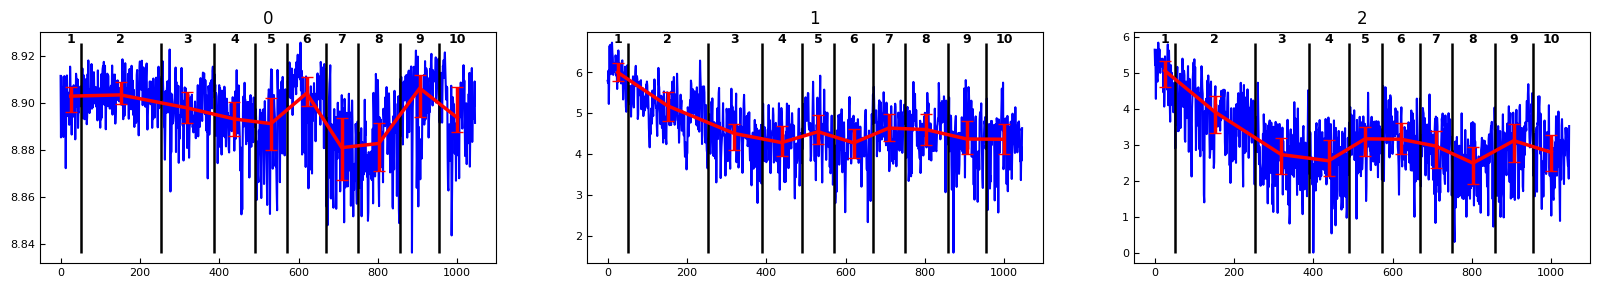

In [33]:
SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/features.svg")

#### Lengths of stages

In [34]:
stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
stage_timing.to_csv(f"{subj}/{exp}/stage_timing.csv")
display(stage_timing)

,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(9.9, 55.5)","(56.3, 236.3)","(237.1, 359.5)","(360.3, 453.1)","(454.7, 522.7)","(523.5, 610.7)","(611.5, 678.7)","(679.5, 771.5)","(772.3, 859.5)","(860.3, 938.7)"
"Time length, sec",45.6,180.0,122.4,92.8,68.0,87.2,67.2,92.0,87.2,78.4
Number of epochs,52,200,136,102,82,98,79,108,98,91


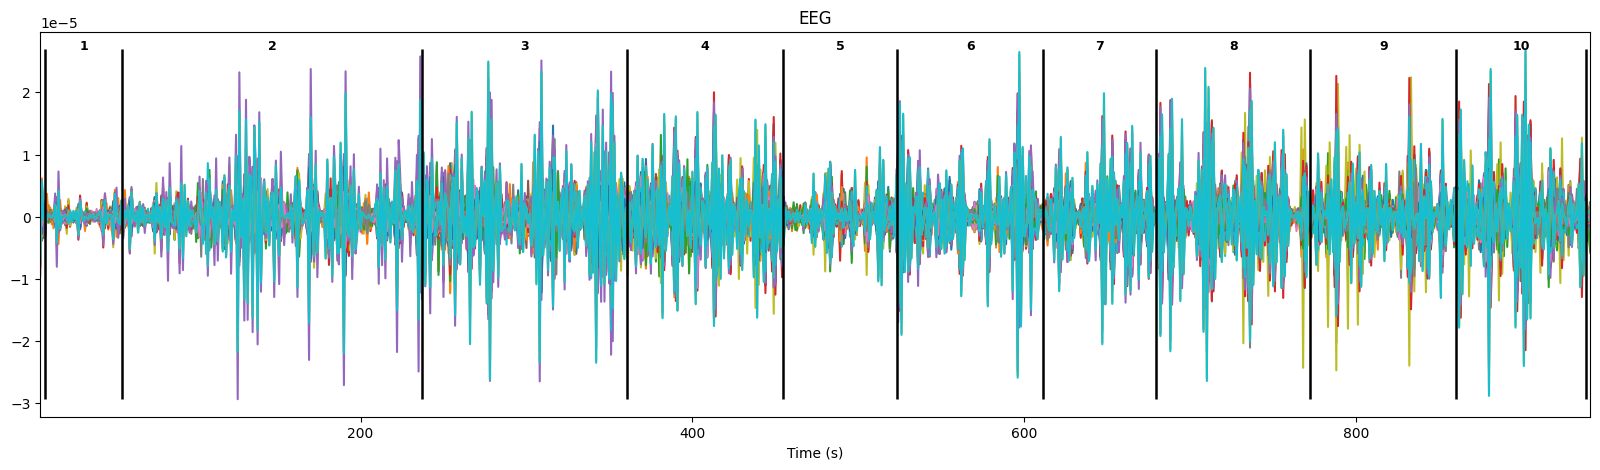

In [64]:
SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/eeg_stages.svg")

#### Overall stats

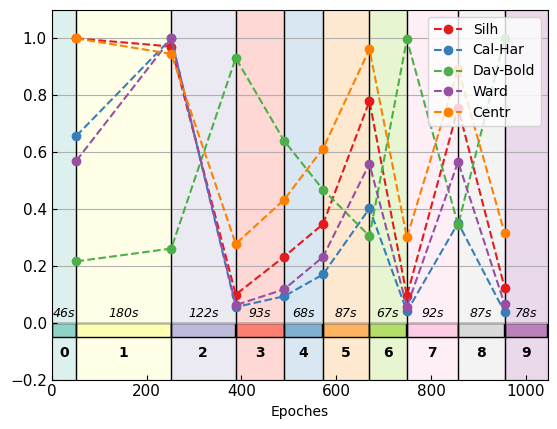

In [116]:
SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/stats.svg")